In [1]:
##vocab production script
#imports
import multiprocessing
from multiprocessing import Pool
import math, random, sys
import pickle
import argparse
from functools import partial
import torch
import numpy
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from hgraph import MolGraph, common_atom_vocab, PairVocab
import rdkit
import rdkit.Chem as Chem
import networkx as nx
from hgraph.chemutils import *
from hgraph.nnutils import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
import time
from rdkit.Chem import Draw
import itertools
from collections import Counter

/home/marcase/.conda/envs/hgraph-rdkit/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


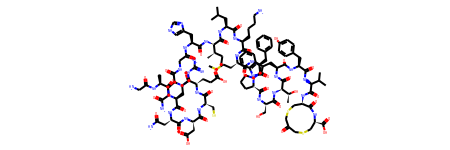

In [2]:
peptide = 'OC(C[C@@H](C(N[C@H](C(N[C@H](C(N[C@H](C(NCC(N[C@H](C(N[C@@]([H])([C@@H](C)CC)C(N[C@@H](CC(C)C)C(N[C@H](C(N[C@H](C(N[C@@H](CC1=CC=CC=C1)C(N2CCC[C@H]2C(N[C@H](C(N[C@@]([C@H](O)C)(C(N[C@H](C(N[C@H](C(N[C@H](C(N[C@H](C(N[C@H](C(O)=O)CSC3)=O)CSCC3=O)=O)C(C)C)=O)CC4=CC=C(O)C=C4)=O)CC5=CNC6=C5C=CC=C6)=O)[H])=O)CO)=O)=O)=O)CCSC)=O)CCCCN[H])=O)=O)=O)CC7=CNC=N7)=O)=O)CCC(N)=O)=O)CCC(O)=O)=O)CS[H])=O)NC([C@@H](NC([C@@H](NC([C@H](C)NC(CN)=O)=O)CCCNC(N)=N)=O)CC(N)=O)=O)=O'
peptide = get_mol(peptide)
peptide

In [111]:
#define matches for side chain traversal
match_molecule = 'O=CN[C@H3]'
matches = peptide.GetSubstructMatches(Chem.MolFromSmiles(match_molecule),useChirality=True)
# print(matches)

#define matches with overlap for clusters (for tree_decomp method)
match_molecule_with_overlap = 'O=C(C)NC'
matches_with_overlap = peptide.GetSubstructMatches(Chem.MolFromSmiles(match_molecule_with_overlap),useChirality=True)
matches_with_overlap
# print(matches_with_overlap)

#separately define proline, because the backbone creates double recognition
proline = 'O=CN1CCC[C@H2]1'
proline_matches = peptide.GetSubstructMatches(Chem.MolFromSmiles(proline),useChirality=True)
proline_match_ids = np.hstack(proline_matches)
for index,proline_match in enumerate(proline_matches):
    proline_O = proline_match[0]
    
#update cluster with correct proline cluster
clusters = [i for i in np.array(matches_with_overlap).reshape(23,5)]
clusters = [cluster for cluster in clusters if proline_O not in cluster]
[clusters.append(np.array(proline_match)) for proline_match in proline_matches]
# clusters

#remove proline cluster from match and match_with_overlap
matches = [match for match in matches if not any([x in proline_match_ids for x in match])]

backbone_atoms = np.array(matches).reshape((21,4))
c_alphas = backbone_atoms[:,3]
backbone_atoms = np.hstack(np.array(backbone_atoms))
backbone_atoms = np.concatenate((backbone_atoms,np.hstack([proline_match for proline_match in proline_matches])))


backbone_atoms_with_overlap = np.hstack(np.array(matches_with_overlap)[:,[2,4]])
backbone_atoms_with_overlap
backbone_atoms_with_overlap = Counter(backbone_atoms_with_overlap)

termini = list([atom for atom in backbone_atoms_with_overlap if (backbone_atoms_with_overlap[atom]==1) and (atom not in proline_match_ids)])

#assign n and c terminus based on # of bonds to other atoms
if len(peptide.GetAtomWithIdx(int(termini[1])).GetNeighbors()) == 2:
    n_terminal_atom = int(termini[1])
    c_terminal_atom = int(termini[0])
else:
    c_terminal_atom = int(termini[1])
    n_terminal_atom = int(termini[0])

#extract atom indices of the n terminus
n_terminus = np.array([],dtype=int)
for neighbor in peptide.GetAtomWithIdx(n_terminal_atom).GetNeighbors():
    if neighbor.GetIdx() not in backbone_atoms:
        n_terminus = np.append(n_terminus, int(neighbor.GetIdx()))

n_terminus = np.append(n_terminus, n_terminal_atom)
clusters.append(n_terminus)

#extract atom indices of the c terminus
c_terminus = np.array([],dtype=int) 
for neighbor in peptide.GetAtomWithIdx(c_terminal_atom).GetNeighbors():
    if neighbor.GetIdx() not in backbone_atoms:
        if 8 in [atom.GetAtomicNum() for atom in peptide.GetAtomWithIdx(neighbor.GetIdx()).GetNeighbors()]:
            c_terminus = np.append(c_terminus, [int(new_neighbor.GetIdx()) for new_neighbor in peptide.GetAtomWithIdx(neighbor.GetIdx()).GetNeighbors()])
            c_terminus = np.append(c_terminus, [neighbor.GetIdx()])
clusters.append(c_terminus)
clusters

[array([85, 76, 75, 77, 78]),
 array([91, 73, 72, 74, 75]),
 array([95, 70, 69, 71, 72]),
 array([104,  67,  66,  68,  69]),
 array([115,  64,  60,  65,  66]),
 array([116,  58,  57,  59,  60]),
 array([119,  55,  54,  56,  57]),
 array([121,  39,  38,  40,  41]),
 array([126,  36,  35,  37,  38]),
 array([132,  33,  28,  34,  35]),
 array([133,  26,  21,  27,  28]),
 array([134,  19,  18,  20,  21]),
 array([141,  16,  15,  17,  18]),
 array([142,  13,  12,  14,  15]),
 array([148,  10,   9,  11,  12]),
 array([154,   7,   6,   8,   9]),
 array([157,   4,   3,   5,   6]),
 array([172, 169, 170, 168, 166]),
 array([173, 165, 166, 164, 163]),
 array([181, 162, 163, 161, 160]),
 array([186, 159, 160, 158,   3]),
 array([120,  49,  50,  51,  52,  53,  54]),
 array([171, 170]),
 array([78, 80, 81, 79])]

In [112]:
##recursively identify alpha carbons, and map the atom indices that contain their side chains
c_alphas_neighbors = [peptide.GetAtomWithIdx(int(x)).GetNeighbors() for x in c_alphas]

for index,c_alpha in enumerate(c_alphas):
    c_alpha_neighbors = peptide.GetAtomWithIdx(int(c_alpha)).GetNeighbors()
    # print('starting c_alpha atom index: ' + str(c_alpha))
    # print('neighbor indices: ' +str([neighbor.GetIdx() for neighbor in c_alpha_neighbors]))
    # print('neighbor atomic masses: ' + str([neighbor.GetAtomicNum() for neighbor in c_alpha_neighbors]))
    # print('starting atoms: ' + str([c_alpha_neighbor.GetIdx() for c_alpha_neighbor in c_alpha_neighbors]))
    if c_alpha == c_terminal_atom:
        # print('c terminus skipped: ' + str(c_alpha))
        continue
    if c_alpha in proline_match_ids:
        # print('skipped proline')
        continue
    for neighbor in c_alpha_neighbors:
        if (neighbor.GetIdx() not in backbone_atoms) and (neighbor.GetAtomicNum() == 6):
            # print('starting side chain atom: '+str(neighbor.GetIdx()) + ', atomic num: ' + str(neighbor.GetAtomicNum()))
            side_chain_atoms = np.array([neighbor.GetIdx()])
            new_neighbors = neighbor.GetNeighbors()
            # print('starting neighbor atom(s): ' + str([new_neighbor.GetIdx() for new_neighbor in new_neighbors]) + ', atomic num(s): ' + str([new_neighbor.GetAtomicNum() for new_neighbor in new_neighbors]))
            atoms_to_examine = np.array([])
            while(len(new_neighbors) > 0):
                for new_neighbor in new_neighbors:
                    if (new_neighbor.GetIdx() not in side_chain_atoms) and (new_neighbor.GetIdx() not in backbone_atoms):
                        # print('new neighbor atom found, index: ' + str(new_neighbor.GetIdx()))
                        side_chain_atoms = np.append(side_chain_atoms,new_neighbor.GetIdx())
                        # print('side_chain_atom(s): ' + str(side_chain_atoms))
                        atoms_to_examine = np.append(atoms_to_examine,new_neighbor.GetIdx())
                        # print('atom(s) to examine: ' + str(atoms_to_examine))
                    elif new_neighbor.GetIdx()  in side_chain_atoms:
                        # print('already found this atom in side chain: ' + str(new_neighbor.GetIdx()))
                        continue
                    elif new_neighbor.GetIdx() in backbone_atoms:
                        # print('already found this atom in back bone: ' + str(new_neighbor.GetIdx()))
                        continue
                if len(atoms_to_examine) == 0:
                    # print('no new atoms to explore')
                    break
                else:
                    new_neighbors = np.hstack([peptide.GetAtomWithIdx(int(atom)).GetNeighbors() for atom in atoms_to_examine])
                    # print('new neighbors to investigate: ' + str([new_neighbor.GetIdx() for new_neighbor in new_neighbors]))
                    atoms_to_examine = np.array([])
            # print('complete mapped side chain: ' + str([x for x in side_chain_atoms]))
            clusters.append(np.concatenate([np.array([x for x in side_chain_atoms]),np.array([c_alpha])]))
    #neighbors are not in a consistent order

clusters
# [peptide.GetAtomWithIdx(x).GetNeighbors() for x in c_alphas]

[array([85, 76, 75, 77, 78]),
 array([91, 73, 72, 74, 75]),
 array([95, 70, 69, 71, 72]),
 array([104,  67,  66,  68,  69]),
 array([115,  64,  60,  65,  66]),
 array([116,  58,  57,  59,  60]),
 array([119,  55,  54,  56,  57]),
 array([121,  39,  38,  40,  41]),
 array([126,  36,  35,  37,  38]),
 array([132,  33,  28,  34,  35]),
 array([133,  26,  21,  27,  28]),
 array([134,  19,  18,  20,  21]),
 array([141,  16,  15,  17,  18]),
 array([142,  13,  12,  14,  15]),
 array([148,  10,   9,  11,  12]),
 array([154,   7,   6,   8,   9]),
 array([157,   4,   3,   5,   6]),
 array([172, 169, 170, 168, 166]),
 array([173, 165, 166, 164, 163]),
 array([181, 162, 163, 161, 160]),
 array([186, 159, 160, 158,   3]),
 array([120,  49,  50,  51,  52,  53,  54]),
 array([171, 170]),
 array([78, 80, 81, 79]),
 array([86, 87, 88, 89, 90, 84, 83, 82, 75]),
 array([92, 93, 94, 72]),
 array([ 96,  97,  98, 103,  99, 102, 100, 101,  69]),
 array([105, 106, 107, 110, 108, 109, 111, 114, 112, 113,  66]

In [113]:
#check if all atoms are in a cluster
test = np.hstack(clusters)
test = set(np.sort(test))
if len(test) == len(peptide.GetAtoms()):
    print('molecule clusters identified correctly')

molecule clusters identified correctly


In [114]:
#get atom_cls
atom_cls = [[] for i in range(len(peptide.GetAtoms()))]
for i in range(len(clusters)):
    for atom in clusters[i]:
        atom_cls[atom].append(i)

In [115]:
clusters

[array([85, 76, 75, 77, 78]),
 array([91, 73, 72, 74, 75]),
 array([95, 70, 69, 71, 72]),
 array([104,  67,  66,  68,  69]),
 array([115,  64,  60,  65,  66]),
 array([116,  58,  57,  59,  60]),
 array([119,  55,  54,  56,  57]),
 array([121,  39,  38,  40,  41]),
 array([126,  36,  35,  37,  38]),
 array([132,  33,  28,  34,  35]),
 array([133,  26,  21,  27,  28]),
 array([134,  19,  18,  20,  21]),
 array([141,  16,  15,  17,  18]),
 array([142,  13,  12,  14,  15]),
 array([148,  10,   9,  11,  12]),
 array([154,   7,   6,   8,   9]),
 array([157,   4,   3,   5,   6]),
 array([172, 169, 170, 168, 166]),
 array([173, 165, 166, 164, 163]),
 array([181, 162, 163, 161, 160]),
 array([186, 159, 160, 158,   3]),
 array([120,  49,  50,  51,  52,  53,  54]),
 array([171, 170]),
 array([78, 80, 81, 79]),
 array([86, 87, 88, 89, 90, 84, 83, 82, 75]),
 array([92, 93, 94, 72]),
 array([ 96,  97,  98, 103,  99, 102, 100, 101,  69]),
 array([105, 106, 107, 110, 108, 109, 111, 114, 112, 113,  66]

In [116]:
atom_cls

[[42],
 [42],
 [42],
 [16, 20, 42],
 [16],
 [16],
 [15, 16, 38],
 [15],
 [15],
 [14, 15, 37],
 [14],
 [14],
 [13, 14, 36],
 [13],
 [13],
 [12, 13],
 [12],
 [12],
 [11, 12, 35],
 [11],
 [11],
 [10, 11, 34],
 [34],
 [34],
 [34],
 [34],
 [10],
 [10],
 [9, 10, 33],
 [33],
 [33],
 [33],
 [33],
 [9],
 [9],
 [8, 9, 32],
 [8],
 [8],
 [7, 8, 31],
 [7],
 [7],
 [7, 30],
 [30],
 [30],
 [30],
 [30],
 [30],
 [30],
 [30],
 [21],
 [21],
 [21],
 [21],
 [21],
 [6, 21],
 [6],
 [6],
 [5, 6, 29],
 [5],
 [5],
 [4, 5, 28],
 [28],
 [28],
 [28],
 [4],
 [4],
 [3, 4, 27],
 [3],
 [3],
 [2, 3, 26],
 [2],
 [2],
 [1, 2, 25],
 [1],
 [1],
 [0, 1, 24],
 [0],
 [0],
 [0, 23],
 [23],
 [23],
 [23],
 [24],
 [24],
 [24],
 [0],
 [24],
 [24],
 [24],
 [24],
 [24],
 [1],
 [25],
 [25],
 [25],
 [2],
 [26],
 [26],
 [26],
 [26],
 [26],
 [26],
 [26],
 [26],
 [3],
 [27],
 [27],
 [27],
 [27],
 [27],
 [27],
 [27],
 [27],
 [27],
 [27],
 [4],
 [5],
 [29],
 [29],
 [6],
 [21],
 [7],
 [31],
 [31],
 [31],
 [31],
 [8],
 [32],
 [32],
 [32],
 [3